In [2]:
import os
from os import path
from PIL import Image
import skimage.io as skio
import numpy as np
import matplotlib.pyplot as plt
!pip install slideio
import slideio
# slideio documentation: https://towardsdatascience.com/slideio-a-new-python-library-for-reading-medical-images-11858a522059

!git clone https://github.com/vqdang/hover_net

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 12.5 MB/s eta 0:00:00
Cloning into 'hover_net'...
remote: Enumerating objects: 2028, done.
remote: Counting objects: 100% (511/511), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 2028 (delta 434), reused 412 (delta 412), pack-reused 1517
Receiving objects: 100% (2028/2028), 40.39 MiB | 11.35 MiB/s, done.
Resolving deltas: 100% (1247/1247), done.


In [ ]:
#downloading data to workspace and renaming the training and testing folders

!gdown 1G54vsOdxWY1hG7dzmkeK3r0xz9s-heyQ -O /content/MoNuSAC_Testing_Data_and_Annotations.zip #download
#!unzip -j /content/MoNuSAC_Testing_Data_and_Annotations.zip -d /content/MoNuSAC_Testing_Data_and_Annotations
!unzip /content/MoNuSAC_Testing_Data_and_Annotations.zip #-d /content/MoNuSAC_Testing_Data_and_Annotations

!gdown 1lxMZaAPSpEHLSxGA9KKMt_r-4S8dwLhq -O /content/MoNuSAC_Training_Data_and_Annotations.zip
#!unzip -j /content/MoNuSAC_Training_Data_and_Annotations.zip -d /content/MoNuSAC_Training_Data_and_Annotations
!unzip /content/MoNuSAC_Training_Data_and_Annotations.zip #-d /content/MoNuSAC_Training_Data_and_Annotations

os.rename("MoNuSAC_images_and_annotations", "MoNuSAC_Training_Data_and_Annotations")
os.rename("MoNuSAC Testing Data and Annotations", "MoNuSAC_Testing_Data_and_Annotations")

In [4]:
#configuration

access_to_masks = True # if you want to create the masks yourself set this parameter to False (True because the access is open to everyone)
download = False # if you want to create and download the zip folder MoNuSAC_masks once you have created them yourself

Analysing the files in the dataset

In [ ]:
os.chdir(r'/content/MoNuSAC_Training_Data_and_Annotations/TCGA-86-8672-01Z-00-DX1')
# Opening and viewing an SVS file
filename = 'TCGA-86-8672-01Z-00-DX1_1.svs'
slide = slideio.open_slide(filename,"SVS")
scene = slide.get_scene(0)
image = scene.read_block(
    #size=(500,0)
    )
plt.imshow(image, cmap = 'gray')
image.shape

# Opening and viewing a TIF file
# WARNING: does not open multichannel

filename = 'TCGA-86-8672-01Z-00-DX1_1.tif'
im = Image.open(filename)
im.show()
# to numpy
tif_np=np.asarray(im)
tif_np = np.rollaxis(tif_np, 2, 0)[:-1]
tif_np.shape

We can observe how the image formats carry the same information so we can freely choose which to use

Downloading the mask to workspace after having created them with authors code

In [ ]:
os.chdir('/content')

if(access_to_masks):
  !gdown 1NkGrjb39tA7hmPi7QrZ3B0unFMDDcisg -O /content/MoNuSAC_masks.zip 
  !unzip /content/MoNuSAC_masks.zip 

else:
  !apt update && apt install -y openslide-tools
  !pip install openslide-python
  !gdown 1j1rzXG_PcH2CtBsV-OEZIjRbILs_ad-s -O /content/masks_generator.py 
  import masks_generator

  if(download):
    from google.colab import files
    !zip -r /content/MoNuSAC_masks.zip /content/MoNuSAC_masks
    files.download('/content/MoNuSAC_masks.zip')

Creating Dataset class of Pytorch

In [6]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

In [71]:
#useful functions for the MonusacDataset class

def count_images(folder):
  '''Counts the images in all the subfolders of folder or in folder if it does not have subfolders'''
  
  len=0
  os.chdir(folder)
  subfolders=[f.path for f in os.scandir(folder) if f.is_dir()]
  if subfolders == []:
    for file_name in os.listdir():
      if file_name.endswith('.xml'):
        len+=1
  else:
    for subfolder in os.listdir():
      os.chdir(subfolder)
      for file_name in os.listdir():
        if file_name.endswith('.xml'):
          len+=1
      parent_path = os.path.abspath('..')     # parent folder path
      os.chdir(parent_path)       # move to parent

  return len

def open_masks(masks_folder_path, image_shape):
  '''Finds all the masks regarding epithelial cells, lymphocytes, macrophages and neutrophils in MoNuSAC_masks'''

  mask_shape = list(image_shape)
  mask_shape[-1] = 1
  mask_shape = tuple(mask_shape)

  try:
    epithelial = skio.imread(os.path.join(masks_folder_path, 'Epithelial', os.listdir(masks_folder_path+'/Epithelial')[0]), plugin="tifffile")
  except:
    epithelial = np.zeros(mask_shape)

  try:
    lymphocyte = skio.imread(os.path.join(masks_folder_path, 'Lymphocyte', os.listdir(masks_folder_path+'/Lymphocyte')[0]), plugin="tifffile")
  except:
    lymphocyte = np.zeros(mask_shape)

  try:
    macrophage = skio.imread(os.path.join(masks_folder_path, 'Macrophage', os.listdir(masks_folder_path+'/Macrophage')[0]), plugin="tifffile")
  except:
    macrophage = np.zeros(mask_shape)

  try:
    neutrophil = skio.imread(os.path.join(masks_folder_path, 'Neutrophil', os.listdir(masks_folder_path+'/Neutrophil')[0]), plugin="tifffile")
  except:
    neutrophil = np.zeros(mask_shape)
  
  os.chdir('/content')
    
  return epithelial, lymphocyte, macrophage, neutrophil

In [9]:
print(count_images(r"/content/MoNuSAC_Training_Data_and_Annotations"),count_images(r"/content/MoNuSAC_Training_Data_and_Annotations/TCGA-69-A59K-01Z-00-DX1"), sep='\n')

209
4


In [72]:
from glob import glob

class MonusacDataset(Dataset):
    '''MoNuSAC Dataset.'''

    def __init__(self, img_dir, masks_dir, transform=None):
        '''
        Arguments:
            img_dir (string): Directory with all the images.
            mask_dir (string): Directory with all the masks.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        '''

        self.img_dir = img_dir
        self.masks_dir = masks_dir
        self.transform = transform

    def __len__(self):
        return count_images(self.img_dir)

    def __getitem__(self, idx):
      
      #image extraction
      images = [y for x in os.walk(self.img_dir) for y in glob(os.path.join(x[0], '*.tif'))]

      img_path = images[idx]
      img_path = os.path.normpath(img_path)
      path_as_list = img_path.split('/')
      patient_code = path_as_list[-2]
      img_name = path_as_list[-1].split('.')[0]
      image = Image.open(images[idx])
      image = np.asarray(image)

      #mask extraction
      img_masks = []

      masks_folder_path = os.path.join(self.masks_dir, patient_code, img_name)
      ep, lym, macro, neutr = open_masks(masks_folder_path, image.shape)
      

      sample = {'name': img_name, 'image': image, 'mask_ep': ep, 'mask_lym': lym, 'mask_macro': macro, 'mask_neutr': neutr}

      if self.transform:
        sample = self.transform(sample)

      return sample

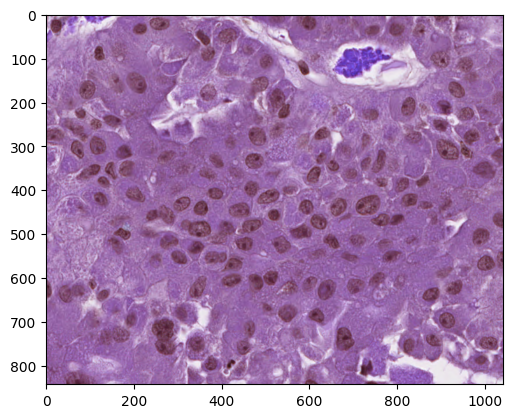

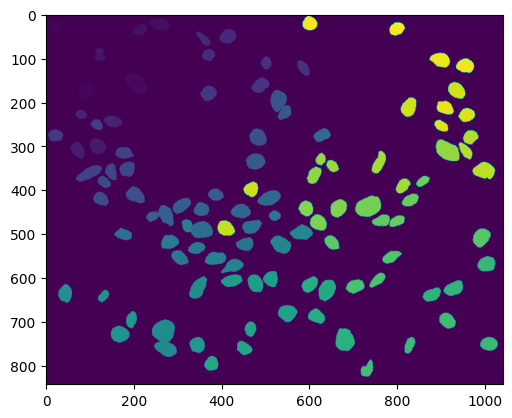

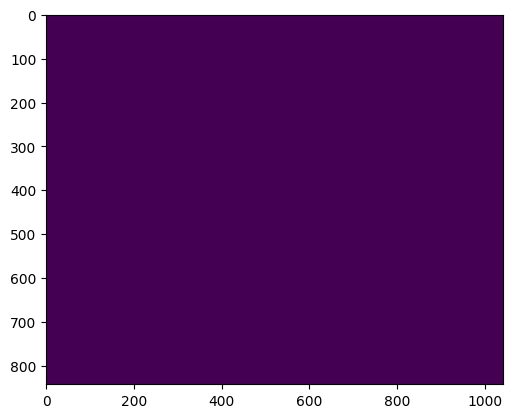

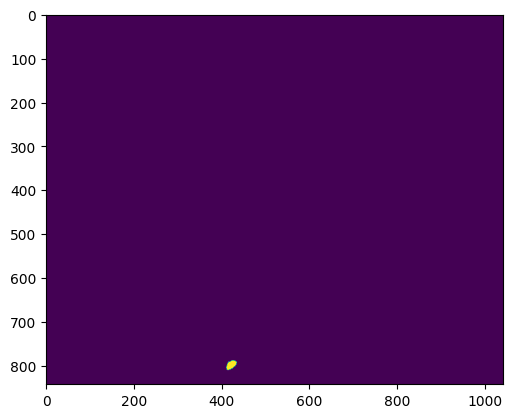

TCGA-B9-A8YI-01Z-00-DX1_2


In [74]:
os.chdir('/content')
from torch._C import NoneType

dataset_mon = MonusacDataset(r'/content/MoNuSAC_Training_Data_and_Annotations', r'/content/MoNuSAC_masks')
sample = dataset_mon[4]

image_example = sample['image']
image_example = plt.imshow(image_example)
plt.show()

mask_ep = sample['mask_ep']
mask_ep = plt.imshow(mask_ep)
plt.show()

mask_lym = sample['mask_lym']
mask_lym = plt.imshow(mask_lym)
plt.show()

mask_neutr = sample['mask_neutr']
mask_neutr = plt.imshow(mask_neutr)
plt.show()

print(sample['name'])

In [62]:
import re
from glob import glob
import os
import tqdm
import pathlib
import numpy as np

from hover_net.misc.patch_extractor import PatchExtractor
from hover_net.misc.utils import rm_n_mkdir

from hover_net.dataset import get_dataset

In [63]:
os.chdir('/content')
# -------------------------------------------------------------------------------------
if __name__ == '__main__':

    # Determines whether to extract type map (only applicable to datasets with class labels).
    type_classification = True

    win_size = [540, 540]
    step_size = [164, 164]
    extract_type = 'mirror'  # Choose 'mirror' or 'valid'. 'mirror'- use padding at borders. 'valid'- only extract from valid regions.

    # Name of dataset - use Kumar, CPM17 or CoNSeP.
    # This used to get the specific dataset img and ann loading scheme from dataset.py
    dataset_name = 'MoNuSac'
    save_root = '/content/patches'

    # a dictionary to specify where the dataset path should be
    dataset_info = {
        'train': {
            'img': ('.tif', '/content/MoNuSAC_Training_Data_and_Annotations'),
            'ann': ('.tif', '/content/MoNuSAC_masks'),
        },
        'valid': {
            'img': ('.tif', '/content/MoNuSAC_Training_Data_and_Annotations'),
            'ann': ('.tif', '/content/MoNuSAC_masks'),
        },
    }

    # patterning = lambda x: re.sub('([\[\]])', '[\\1]', x) # anonymous function that replaces substring ([\[\]]) with substring [\\1] in string x
    parser = MonusacDataset
    xtractor = PatchExtractor(win_size, step_size)
    for split_name, split_desc in dataset_info.items():
        img_ext, img_dir = split_desc['img']
        ann_ext, ann_dir = split_desc['ann']

        out_dir = '%s/%s/%s/%dx%d_%dx%d/' % (
            save_root,
            dataset_name,
            split_name,
            win_size[0],
            win_size[1],
            step_size[0],
            step_size[1],
        )
        # file_list = glob(patterning("%s/*%s" % (ann_dir, ann_ext)))
        # file_list.sort()  # ensure same ordering across platform

        rm_n_mkdir(out_dir)

        pbar_format = "Process File: |{bar}| {n_fmt}/{total_fmt}[{elapsed}<{remaining},{rate_fmt}]"
        pbarx = tqdm.tqdm(
            total=len(dataset_mon), bar_format=pbar_format, ascii=True, position=0
        )

Process File: |          | 0/209[00:00<?,?it/s]


In [ ]:
for file_idx in range(len(dataset_mon)):
  base_name = dataset_mon[file_idx]['name']

  img = dataset_mon[file_idx]['image']
  ep = dataset_mon[file_idx]['mask_ep']
  lym = dataset_mon[file_idx]['mask_lym']
  macro = dataset_mon[file_idx]['mask_macro']
  neutr = dataset_mon[file_idx]['mask_neutr']

  # *
  miao = np.concatenate([img, ep, lym, macro, neutr], axis=-1)
  print('ciaooo %d',file_idx)

In [121]:
        for file_idx in range(len(dataset_mon)):
          base_name = dataset_mon[file_idx]['name']

          img = dataset_mon[file_idx]['image']
          ep = dataset_mon[file_idx]['mask_ep']
          lym = dataset_mon[file_idx]['mask_lym']
          macro = dataset_mon[file_idx]['mask_macro']
          neutr = dataset_mon[file_idx]['mask_neutr']

          # *
          img = np.concatenate([img, ep, lym, macro, neutr], axis=-1)
          sub_patches = xtractor.extract(img, extract_type)

          pbar_format = "Extracting  : |{bar}| {n_fmt}/{total_fmt}[{elapsed}<{remaining},{rate_fmt}]"
          pbar = tqdm.tqdm(
              total=len(sub_patches),
              leave=False,
              bar_format=pbar_format,
              ascii=True,
              position=1,
          )

          for idx, patch in enumerate(sub_patches):
              np.save("{0}/{1}_{2:03d}.npy".format(out_dir, base_name, idx), patch)
              pbar.update()
          pbar.close()
          # *

          pbarx.update()
      pbarx.close()

IndentationError: ignored

In [33]:
!pip install -Uqq ipdb
import ipdb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.1 MB/s eta 0:00:00


In [45]:
%pdb off

Automatic pdb calling has been turned OFF


In [70]:
print(os.listdir('/content'))

['.config', 'MoNuSAC_Training_Data_and_Annotations.zip', 'patches', 'hover_net', 'MoNuSAC_masks', 'MoNuSAC_Testing_Data_and_Annotations', 'MoNuSAC_Testing_Data_and_Annotations.zip', 'MoNuSAC_Training_Data_and_Annotations', 'MoNuSAC_masks.zip', 'sample_data']
